In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


In [2]:
users = pd.read_csv("takehome_users.csv", encoding="latin-1")
eng = pd.read_csv("takehome_user_engagement.csv")

users.head(), eng.head()


(   object_id        creation_time               name                       email creation_source  last_session_creation_time  \
 0          1  2014-04-22 03:53:30     Clausen August    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
 1          2  2013-11-15 03:45:04      Poole Matthew      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
 2          3  2013-03-19 23:14:52  Bottrill Mitchell  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
 3          4  2013-05-21 08:09:28    Clausen Nicklas   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
 4          5  2013-01-17 10:14:20          Raw Grace          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   
 
    opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  invited_by_user_id  
 0                         1                           0      11             10803.0  
 1                         0                      

In [3]:
print(users.shape)
print(eng.shape)

users.isna().mean().sort_values(ascending=False).head(15)


(12000, 10)
(207917, 3)


invited_by_user_id            0.46525
last_session_creation_time    0.26475
object_id                     0.00000
creation_time                 0.00000
name                          0.00000
email                         0.00000
creation_source               0.00000
opted_in_to_mailing_list      0.00000
enabled_for_marketing_drip    0.00000
org_id                        0.00000
dtype: float64

In [4]:
eng2 = eng.copy()
eng2["time_stamp"] = pd.to_datetime(eng2["time_stamp"])
eng2["date"] = eng2["time_stamp"].dt.normalize()

# If there are any duplicate rows for same user-day, drop them
eng2 = eng2.drop_duplicates(["user_id", "date"]).sort_values(["user_id", "date"])
eng2.head()


,time_stamp,user_id,visited,date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [5]:
def is_adopted(dates):
    """
    dates: sorted numpy array of dtype datetime64[D] (unique days)
    adopted if >=3 days within any 7-day window.
    """
    i = 0
    for j in range(len(dates)):
        while dates[j] - dates[i] > np.timedelta64(6, "D"):
            i += 1
        if (j - i + 1) >= 3:
            return 1
    return 0

adopted = (
    eng2.groupby("user_id")["date"]
       .apply(lambda s: is_adopted(s.values.astype("datetime64[D]")))
       .reset_index()
       .rename(columns={"user_id":"object_id", "date":"adopted"})
)

adopted["adopted"].value_counts(dropna=False), adopted.head()


(adopted
 0    7221
 1    1602
 Name: count, dtype: int64,
    object_id  adopted
 0          1        0
 1          2        1
 2          3        0
 3          4        0
 4          5        0)

In [6]:
# Adoption rate
adoption_rate = adopted["adopted"].mean()
print(f"Adopted users: {adopted['adopted'].sum()} / {len(adopted)} ({adoption_rate:.2%})")


Adopted users: 1602 / 8823 (18.16%)


In [7]:
u = users.copy()
u["creation_time"] = pd.to_datetime(u["creation_time"])

# Signup timing features (available at signup)
u["creation_dow"] = u["creation_time"].dt.dayofweek
u["creation_hour"] = u["creation_time"].dt.hour

# Team context proxy: org size
u["org_size"] = u.groupby("org_id")["object_id"].transform("count")

# Invited vs not
u["was_invited"] = u["invited_by_user_id"].notna().astype(int)

# Drop leakage / identifiers
drop_cols = ["name", "email", "creation_time", "last_session_creation_time", "invited_by_user_id"]
X = u.drop(columns=[c for c in drop_cols if c in u.columns])

X.head()


,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,creation_dow,creation_hour,org_size,was_invited
0,1,GUEST_INVITE,1,0,11,1,3,75,1
1,2,ORG_INVITE,0,0,1,4,3,233,1
2,3,ORG_INVITE,0,0,94,1,23,32,1
3,4,GUEST_INVITE,0,0,1,1,8,233,1
4,5,GUEST_INVITE,0,0,193,3,10,16,1


In [8]:
# Merge labels + fill non-engaged users as 0

df = X.merge(adopted, on="object_id", how="left")
df["adopted"] = df["adopted"].fillna(0).astype(int)

df["adopted"].value_counts(), df.shape


(adopted
 0    10398
 1     1602
 Name: count, dtype: int64,
 (12000, 10))

In [9]:
# Adoption by creation_source
adopt_by_source = (
    df.groupby("creation_source")["adopted"]
      .agg(["mean", "count"])
      .sort_values("mean", ascending=False)
)

adopt_by_source


,mean,count
creation_source,,
SIGNUP_GOOGLE_AUTH,0.167509,1385
GUEST_INVITE,0.166436,2163
SIGNUP,0.140393,2087
ORG_INVITE,0.129995,4254
PERSONAL_PROJECTS,0.077688,2111


In [10]:
# Adoption by invited vs not
df.groupby("was_invited")["adopted"].agg(["mean","count"])


,mean,count
was_invited,,
0,0.123410,5583
1,0.142278,6417


In [11]:
# Adoption by org_size buckets
bins = pd.cut(df["org_size"], bins=[0,1,2,5,10,20,50,100,10_000], right=True)
df.groupby(bins)["adopted"].agg(["mean","count"]).sort_values("mean", ascending=False)


/var/folders/pp/_9g9bqld5wb47ph0cdnwm7_r0000gn/T/ipykernel_59812/220332960.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(bins)["adopted"].agg(["mean","count"]).sort_values("mean", ascending=False)


,mean,count
org_size,,
"(5, 10]",0.174312,109
"(10, 20]",0.164808,2870
"(20, 50]",0.140579,5769
"(50, 100]",0.106615,1557
"(100, 10000]",0.078559,1693
"(1, 2]",0.000000,2
"(0, 1]",NaN,0
"(2, 5]",NaN,0


In [13]:
# Modeling: Logistic Regression (interpretable) + Random Forest (nonlinear)

y = df["adopted"].astype(int)
X_model = df.drop(columns=["adopted"])

categorical = [c for c in X_model.columns if X_model[c].dtype == "object"]
numeric = [c for c in X_model.columns if c not in categorical]

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.25, random_state=42, stratify=y
)


In [14]:
lr = Pipeline(steps=[
    ("pre", pre),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

lr.fit(X_train, y_train)
p = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print("ROC-AUC:", roc_auc_score(y_test, p))
print("PR-AUC :", average_precision_score(y_test, p))
print(classification_report(y_test, (p >= 0.5).astype(int), digits=3))


Logistic Regression
ROC-AUC: 0.6184048076923077
PR-AUC : 0.1948500512829422
              precision    recall  f1-score   support

           0      0.917     0.404     0.561      2600
           1      0.165     0.762     0.271       400

    accuracy                          0.452      3000
   macro avg      0.541     0.583     0.416      3000
weighted avg      0.817     0.452     0.522      3000



In [15]:
rf = Pipeline(steps=[
    ("pre", pre),
    ("model", RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
p2 = rf.predict_proba(X_test)[:, 1]

print("Random Forest")
print("ROC-AUC:", roc_auc_score(y_test, p2))
print("PR-AUC :", average_precision_score(y_test, p2))
print(classification_report(y_test, (p2 >= 0.5).astype(int), digits=3))


Random Forest
ROC-AUC: 0.545273076923077
PR-AUC : 0.14978912894855975
              precision    recall  f1-score   support

           0      0.866     0.998     0.928      2600
           1      0.000     0.000     0.000       400

    accuracy                          0.865      3000
   macro avg      0.433     0.499     0.464      3000
weighted avg      0.751     0.865     0.804      3000



In [17]:
# Interpretability: Logistic Regression coefficients

# Get feature names after one-hot encoding
ohe = lr.named_steps["pre"].named_transformers_["cat"]
ohe_features = list(ohe.get_feature_names_out(categorical))
all_features = ohe_features + numeric

coefs = lr.named_steps["model"].coef_.ravel()
coef_table = pd.DataFrame({"feature": all_features, "coef": coefs})
coef_table["abs_coef"] = coef_table["coef"].abs()

coef_table.sort_values("abs_coef", ascending=False).head(20)



,feature,coef,abs_coef
2,creation_source_PERSONAL_PROJECTS,-0.540209,0.540209
4,creation_source_SIGNUP_GOOGLE_AUTH,0.350836,0.350836
0,creation_source_GUEST_INVITE,0.193088,0.193088
12,was_invited,0.133393,0.133393
3,creation_source_SIGNUP,0.130621,0.130621
1,creation_source_ORG_INVITE,-0.059696,0.059696
6,opted_in_to_mailing_list,0.033002,0.033002
7,enabled_for_marketing_drip,-0.031324,0.031324
11,org_size,-0.004922,0.004922
9,creation_dow,0.004689,0.004689


In [18]:
# Extract feature importances from RF
ohe_rf = rf.named_steps["pre"].named_transformers_["cat"]
ohe_features_rf = list(ohe_rf.get_feature_names_out(categorical))
all_features_rf = ohe_features_rf + numeric

importances = rf.named_steps["model"].feature_importances_
imp_table = pd.DataFrame({"feature": all_features_rf, "importance": importances}).sort_values("importance", ascending=False)

imp_table.head(20)


,feature,importance
5,object_id,0.242495
8,org_id,0.215064
11,org_size,0.177585
10,creation_hour,0.172071
9,creation_dow,0.103294
6,opted_in_to_mailing_list,0.021586
7,enabled_for_marketing_drip,0.016964
2,creation_source_PERSONAL_PROJECTS,0.014019
1,creation_source_ORG_INVITE,0.007533
0,creation_source_GUEST_INVITE,0.007530


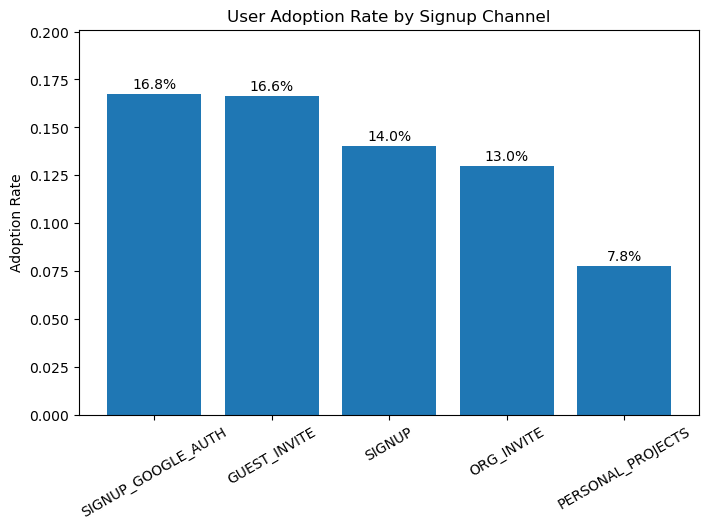

In [19]:
import matplotlib.pyplot as plt

# Use the table you already computed
plot_df = (
    df.groupby("creation_source")["adopted"]
      .agg(["mean", "count"])
      .sort_values("mean", ascending=False)
)

plt.figure(figsize=(8,5))
plt.bar(plot_df.index, plot_df["mean"])
plt.ylabel("Adoption Rate")
plt.title("User Adoption Rate by Signup Channel")

plt.ylim(0, plot_df["mean"].max() * 1.2)
plt.xticks(rotation=30)

# add percent labels
for i, v in enumerate(plot_df["mean"]):
    plt.text(i, v + 0.003, f"{v:.1%}", ha="center")

plt.show()


# Relax Inc — Predicting User Adoption

## 1. Definition of an Adopted User

An **adopted user** is defined as a user who logged into the product on **three distinct days within any rolling seven-day window**.

Using the `takehome_user_engagement` table, login events were deduplicated to one entry per user per day, then a sliding seven-day window was applied to each user’s login history to detect whether at least three unique login days occurred within any such window.

Users meeting this criterion were labeled as **adopted (1)**; all others were labeled **not adopted (0)**.

---

## 2. Dataset Summary

- **Total users:** 12,000  
- **Users with engagement data:** 8,823  
- **Adopted users:** 1,602 (18.2%)

Adoption is a relatively rare event, so **precision-recall AUC (PR-AUC)** is used in addition to ROC-AUC to evaluate model performance.

---

## 3. Features Used (No Leakage)

Only features known at or near signup time were used.  
`last_session_creation_time` was excluded because it contains future behavioral information and would introduce label leakage.

Features included:

- **Acquisition channel**
  - `creation_source` (SIGNUP, SIGNUP_GOOGLE_AUTH, ORG_INVITE, GUEST_INVITE, PERSONAL_PROJECTS)
- **Team context**
  - `org_size` (number of users in the same organization)
  - `was_invited` (whether the user was invited by another user)
- **Signup timing**
  - `creation_dow` (day of week)
  - `creation_hour`
- **Marketing**
  - `opted_in_to_mailing_list`
  - `enabled_for_marketing_drip`

---

## 4. Exploratory Findings

Adoption varies strongly by **how users join the product**.

| Creation Source | Adoption Rate |
|----------------|---------------|
| SIGNUP_GOOGLE_AUTH | 16.8% |
| GUEST_INVITE | 16.6% |
| SIGNUP | 14.0% |
| ORG_INVITE | 13.0% |
| PERSONAL_PROJECTS | 7.8% |

Users joining via **Google authentication or invitations** are about **twice as likely** to become adopted as users who start via **personal projects**.

**Social context also matters:**

- Invited users: 14.2% adoption  
- Non-invited users: 12.3% adoption  

**Organization size matters strongly:**

| Org Size | Adoption Rate |
|---------|---------------|
| 5–10 users | 17.4% |
| 10–20 users | 16.5% |
| 20–50 users | 14.1% |
| 50–100 users | 10.7% |
| 100+ users | 7.9% |

Users in **small teams** are far more likely to become adopted than those in large organizations.

---

## 5. Modeling

Two models were trained using only signup-time features:

- **Logistic Regression** (interpretable)
- **Random Forest** (nonlinear benchmark)

All categorical features were one-hot encoded and class imbalance was handled using built-in weighting. Models were evaluated on a 25% stratified holdout set.

### Model Performance

| Model | ROC-AUC | PR-AUC |
|------|--------|-------|
| Logistic Regression | 0.618 | 0.195 |
| Random Forest | 0.545 | 0.150 |

Logistic regression performed best and was used for interpretation.

---

## 6. Key Predictors of Adoption

From the logistic regression coefficients:

- **Creation source is the strongest driver**
  - `SIGNUP_GOOGLE_AUTH` strongly increases adoption
  - `PERSONAL_PROJECTS` strongly decreases adoption
- **Being invited increases adoption**
- **Larger organizations reduce adoption**
- **Marketing emails have minimal impact**

This shows that **social onboarding and team context** matter far more than marketing or signup timing.

---

## 7. Business Implications

To increase adoption, Relax should:

- Encourage **Google authentication**
- Promote **small-team onboarding**
- Reduce reliance on **personal project signups**
- Improve conversion from **guest to full team member**

---

## 8. Further Data That Would Improve the Model

To better understand *why* users adopt, future analysis would benefit from:

- First-week activity data (projects created, teammates invited, comments, uploads)
- Organization-level activity and subscription plans
- Time-to-first-value metrics

These would allow causal identification of what actions drive adoption rather than just who adopts.
